In [156]:
# !pip install gensim
# !pip install python-Levenshtein

In [157]:
# Let’s load the libraries

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [158]:
#Urls
url_train = 'https://raw.githubusercontent.com/kabirodavies/S_A_Language-Identification/master/train_set.csv'
url_test = 'https://raw.githubusercontent.com/kabirodavies/S_A_Language-Identification/master/test_set.csv'
url_sub = 'https://raw.githubusercontent.com/kabirodavies/S_A_Language-Identification/master/sample_submission.csv'


train = pd.read_csv(url_train)
train.head()


,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekang...
2,eng,the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian...
3,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela ...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa fora...


In [159]:
test = pd.read_csv(url_test)
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlelela kgato eo."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye imitlolo engezelelako ukuqedelela ukutloliswa kwesibawo sakho.
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini naticocisana.
4,5,Winste op buitelandse valuta.


In [160]:
train.shape, test.shape

((33000, 2), (5682, 2))

In [161]:
combi = train.append(test, ignore_index=True, sort=True)
combi.shape

(38682, 3)

In [162]:
combi.head()

,index,lang_id,text
0,NaN,xho,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...
1,NaN,xho,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekang...
2,NaN,eng,the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian...
3,NaN,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela ...
4,NaN,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa fora...


#Text Pre_processing

In [163]:
#Removing Twitter Handles (@user)
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [164]:
combi['tidy_text'] = np.vectorize(remove_pattern)(combi['text'], "@[\w]*") 
combi.head(10)

,index,lang_id,text,tidy_text
0,NaN,xho,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...
1,NaN,xho,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekang...,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekang...
2,NaN,eng,the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian...,the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian...
3,NaN,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela ...,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela ...
4,NaN,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa fora...,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa fora...
5,NaN,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga di tla lebelela diphetogo tša mebaraka ya mešomo le mekgwa ga mmogo le go thapiwa mešomong ka makaleng ao mešomo ao lego molaong le ao a sego molaong ...,dinyakišišo tše tša go dirwa gabedi ka ngwaga di tla lebelela diphetogo tša mebaraka ya mešomo le mekgwa ga mmogo le go thapiwa mešomong ka makaleng ao mešomo ao lego molaong le ao a sego molaong ...
6,NaN,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tshekong go ya ka temana ya a e tshwanetse kwa ntle ga fa kgetse e tsholotswe kgotsa e fetiseditswe kwa kgotlatshekelo ya bana ya fetisediwa kwa kgotlats...,kgetse nngwe le nngwe e e sa faposiwang mo tshekong go ya ka temana ya a e tshwanetse kwa ntle ga fa kgetse e tsholotswe kgotsa e fetiseditswe kwa kgotlatshekelo ya bana ya fetisediwa kwa kgotlats...
7,NaN,ven,mbadelo dze dza laelwa dzi do kwama mahatulele apo a khothe ya madzhisitirata lihoro line la si vhe na mulandu li do vha lone line la wana masheleni ngeno lihoro le la wanwa mulandu li tshi do vha...,mbadelo dze dza laelwa dzi do kwama mahatulele apo a khothe ya madzhisitirata lihoro line la si vhe na mulandu li do vha lone line la wana masheleni ngeno lihoro le la wanwa mulandu li tshi do vha...
8,NaN,nso,maloko a dikhuduthamaga a ikarabela mongwe le mongwe go tonakgolo le go thteramelao ya profense malebana le taolo ya dipotfolio tša bona mme maloko a mangwe ka moka a khuduthamaga le wona bjalo a ...,maloko a dikhuduthamaga a ikarabela mongwe le mongwe go tonakgolo le go thteramelao ya profense malebana le taolo ya dipotfolio tša bona mme maloko a mangwe ka moka a khuduthamaga le wona bjalo a ...
9,NaN,tsn,fa le dirisiwa lebone le tshwanetse go bontsha lesedi le le benyabenyang le le bogale jo bo dirang gore le kgone go bonwa ke motho yo o bonang sentle mo leseding le le tlwaelegileng mo sekgaleng s...,fa le dirisiwa lebone le tshwanetse go bontsha lesedi le le benyabenya

In [165]:
#Removing Punctuations, Numbers, and Special Characters
combi.tidy_text = combi.tidy_text.str.replace("[^a-zA-Z#]", " ")
combi.head(10)

,index,lang_id,text,tidy_text
0,NaN,xho,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...,umgaqo siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...
1,NaN,xho,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekang...,i dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekang...
2,NaN,eng,the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian...,the province of kwazulu natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian...
3,NaN,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela ...,o netefat a gore o ba file dilo ka moka t e le dumelelanego ka t ona mohlala maleri a magolo a a omi wago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go omela ...
4,NaN,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa fora...,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa fora...
5,NaN,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga di tla lebelela diphetogo tša mebaraka ya mešomo le mekgwa ga mmogo le go thapiwa mešomong ka makaleng ao mešomo ao lego molaong le ao a sego molaong ...,dinyaki i o t e t a go dirwa gabedi ka ngwaga di tla lebelela diphetogo t a mebaraka ya me omo le mekgwa ga mmogo le go thapiwa me omong ka makaleng ao me omo ao lego molaong le ao a sego molaong ...
6,NaN,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tshekong go ya ka temana ya a e tshwanetse kwa ntle ga fa kgetse e tsholotswe kgotsa e fetiseditswe kwa kgotlatshekelo ya bana ya fetisediwa kwa kgotlats...,kgetse nngwe le nngwe e e sa faposiwang mo tshekong go ya ka temana ya a e tshwanetse kwa ntle ga fa kgetse e tsholotswe kgotsa e fetiseditswe kwa kgotlatshekelo ya bana ya fetisediwa kwa kgotlats...
7,NaN,ven,mbadelo dze dza laelwa dzi do kwama mahatulele apo a khothe ya madzhisitirata lihoro line la si vhe na mulandu li do vha lone line la wana masheleni ngeno lihoro le la wanwa mulandu li tshi do vha...,mbadelo dze dza laelwa dzi do kwama mahatulele apo a khothe ya madzhisitirata lihoro line la si vhe na mulandu li do vha lone line la wana masheleni ngeno lihoro le la wanwa mulandu li tshi do vha...
8,NaN,nso,maloko a dikhuduthamaga a ikarabela mongwe le mongwe go tonakgolo le go thteramelao ya profense malebana le taolo ya dipotfolio tša bona mme maloko a mangwe ka moka a khuduthamaga le wona bjalo a ...,maloko a dikhuduthamaga a ikarabela mongwe le mongwe go tonakgolo le go thteramelao ya profense malebana le taolo ya dipotfolio t a bona mme maloko a mangwe ka moka a khuduthamaga le wona bjalo a ...
9,NaN,tsn,fa le dirisiwa lebone le tshwanetse go bontsha lesedi le le benyabenyang le le bogale jo bo dirang gore le kgone go bonwa ke motho yo o bonang sentle mo leseding le le tlwaelegileng mo sekgaleng s...,fa le dirisiwa lebone le tshwanetse go bontsha lesedi le le benyabenyang

In [166]:
#Removing Short Words
combi.tidy_text = combi.tidy_text.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
combi.head(10)

,index,lang_id,text,tidy_text
0,NaN,xho,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...,umgaqo siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...
1,NaN,xho,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekang...,dha iya kuba nobulumko bokubeka umsebenzi naphi kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekanga dha...
2,NaN,eng,the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian...,the province kwazulu natal department transport invites tenders from established contractors experienced bridge construction for the construction the kwajolwayo tugela river pedestrian bridge near...
3,NaN,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela ...,netefat gore file dilo moka dumelelanego ona mohlala maleri magolo omi wago fihlelela meagong metelele scaffolds bolokegilego lefelo maleba omela phela gabotse bjbj
4,NaN,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa fora...,khomishini ndinganyiso mbeu ewa maana nga mulayo khomishini ndinganyiso mbeu thetshelesa mbilaelo dzine dza tshimbilelana tshialula nga mbeu nahone ivhea foramu thungo nga mulayo ndinganyiso
5,NaN,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga di tla lebelela diphetogo tša mebaraka ya mešomo le mekgwa ga mmogo le go thapiwa mešomong ka makaleng ao mešomo ao lego molaong le ao a sego molaong ...,dinyaki dirwa gabedi ngwaga tla lebelela diphetogo mebaraka omo mekgwa mmogo thapiwa omong makaleng omo lego molaong sego molaong hloka omo
6,NaN,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tshekong go ya ka temana ya a e tshwanetse kwa ntle ga fa kgetse e tsholotswe kgotsa e fetiseditswe kwa kgotlatshekelo ya bana ya fetisediwa kwa kgotlats...,kgetse nngwe nngwe faposiwang tshekong temana tshwanetse kwa ntle kgetse tsholotswe kgotsa fetiseditswe kwa kgotlatshekelo bana fetisediwa kwa kgotlatshekelo bosiamisi ngwana gore ikarabele tatofa...
7,NaN,ven,mbadelo dze dza laelwa dzi do kwama mahatulele apo a khothe ya madzhisitirata lihoro line la si vhe na mulandu li do vha lone line la wana masheleni ngeno lihoro le la wanwa mulandu li tshi do vha...,mbadelo dze dza laelwa dzi kwama mahatulele apo khothe madzhisitirata lihoro line vhe mulandu vha lone line wana masheleni ngeno lihoro wanwa mulandu tshi vha lone line tea lifha ayo masheleni lae...
8,NaN,nso,maloko a dikhuduthamaga a ikarabela mongwe le mongwe go tonakgolo le go thteramelao ya profense malebana le taolo ya dipotfolio tša bona mme maloko a mangwe ka moka a khuduthamaga le wona bjalo a ...,maloko dikhuduthamaga ikarabela mongwe mongwe tonakgolo thteramelao profense malebana taolo dipotfolio bona mme maloko mangwe moka khuduthamaga wona bjalo ikrabela seboka mabapi phethagat mediro m...
9,NaN,tsn,fa le dirisiwa lebone le tshwanetse go bontsha lesedi le le benyabenyang le le bogale jo bo dirang gore le kgone go bonwa ke motho yo o bonang sentle mo leseding le le tlwaelegileng mo sekgaleng s...,dirisiwa lebone tshwanetse bontsha lesedi benyabenyang bogale dirang gore kgone bonwa motho bonang sentle leseding tlwaelegileng sekgaleng dimitara


#Text Normalization

In [167]:
tokenized_text = combi.tidy_text.apply(lambda x: x.split())
tokenized_text.head()

0    [umgaqo, siseko, wenza, amalungiselelo, kumaziko, axhasa, ulawulo, lwesininzi, kunye, nokuthath, inxaxheba, kwabafazi, ezi, ziquka, phakathi, kwezinye, zazo, ikomishoni, yokulingana, ngokwesini, i...
1    [dha, iya, kuba, nobulumko, bokubeka, umsebenzi, naphi, kwisebe, ngokusekwe, kwiimfuno, zokusebenza, zalo, emva, kokubonana, nomsebenzi, kunye, okanye, imanyano, yakhe, ukuba, ulandulo, lomntu, on...
2    [the, province, kwazulu, natal, department, transport, invites, tenders, from, established, contractors, experienced, bridge, construction, for, the, construction, the, kwajolwayo, tugela, river, ...
3               [netefat, gore, file, dilo, moka, dumelelanego, ona, mohlala, maleri, magolo, omi, wago, fihlelela, meagong, metelele, scaffolds, bolokegilego, lefelo, maleba, omela, phela, gabotse, bjbj]
4    [khomishini, ndinganyiso, mbeu, ewa, maana, nga, mulayo, khomishini, ndinganyiso, mbeu, thetshelesa, mbilaelo, dzine, dza, tshimbilelana, tshialula, nga, mbeu, nahone, ivhea, 

In [168]:
# Now we can normalize the tokenized text.

from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_text.head()

0    [umgaqo, siseko, wenza, amalungiselelo, kumaziko, axhasa, ulawulo, lwesininzi, kunye, nokuthath, inxaxheba, kwabafazi, ezi, ziquka, phakathi, kwezinye, zazo, ikomishoni, yokulingana, ngokwesini, i...
1    [dha, iya, kuba, nobulumko, bokubeka, umsebenzi, naphi, kwisebe, ngokusekwe, kwiimfuno, zokusebenza, zalo, emva, kokubonana, nomsebenzi, kunye, okanye, imanyano, yakhe, ukuba, ulandulo, lomntu, on...
2    [the, province, kwazulu, natal, department, transport, invites, tenders, from, established, contractors, experienced, bridge, construction, for, the, construction, the, kwajolwayo, tugela, river, ...
3               [netefat, gore, file, dilo, moka, dumelelanego, ona, mohlala, maleri, magolo, omi, wago, fihlelela, meagong, metelele, scaffolds, bolokegilego, lefelo, maleba, omela, phela, gabotse, bjbj]
4    [khomishini, ndinganyiso, mbeu, ewa, maana, nga, mulayo, khomishini, ndinganyiso, mbeu, thetshelesa, mbilaelo, dzine, dza, tshimbilelana, tshialula, nga, mbeu, nahone, ivhea, 

In [169]:
# Now let’s stitch these tokens back together. It can easily be done using nltk’s MosesDetokenizer function.

for i in range(len(tokenized_text)):
    tokenized_text[i] = ' '.join(tokenized_text[i])    
train['tidy_text'] = tokenized_text
combi.head(10)

,index,lang_id,text,tidy_text
0,NaN,xho,umgaqo-siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...,umgaqo siseko wenza amalungiselelo kumaziko axhasa ulawulo lwesininzi kunye nokuthath inxaxheba kwabafazi ezi ziquka phakathi kwezinye zazo ikomishoni yokulingana ngokwesini ikomishoni yamalungelo...
1,NaN,xho,i-dha iya kuba nobulumko bokubeka umsebenzi naphi na kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekang...,dha iya kuba nobulumko bokubeka umsebenzi naphi kwisebe ngokusekwe kwiimfuno zokusebenza zalo emva kokubonana nomsebenzi kunye okanye imanyano yakhe ukuba ulandulo lomntu onjalo alufanelekanga dha...
2,NaN,eng,the province of kwazulu-natal department of transport invites tenders from established contractors experienced in bridge construction for the construction of the kwajolwayo tugela river pedestrian...,the province kwazulu natal department transport invites tenders from established contractors experienced bridge construction for the construction the kwajolwayo tugela river pedestrian bridge near...
3,NaN,nso,o netefatša gore o ba file dilo ka moka tše le dumelelanego ka tšona mohlala maleri a magolo a a šomišwago go fihlelela meagong e metelele scaffolds a a bolokegilego lefelo la maleba la go šomela ...,netefat gore file dilo moka dumelelanego ona mohlala maleri magolo omi wago fihlelela meagong metelele scaffolds bolokegilego lefelo maleba omela phela gabotse bjbj
4,NaN,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana u ya nga mulayo wa khomishini ya ndinganyiso ya mbeu u thetshelesa mbilaelo dzine dza tshimbilelana na tshialula u ya nga mbeu nahone i ivhea sa fora...,khomishini ndinganyiso mbeu ewa maana nga mulayo khomishini ndinganyiso mbeu thetshelesa mbilaelo dzine dza tshimbilelana tshialula nga mbeu nahone ivhea foramu thungo nga mulayo ndinganyiso
5,NaN,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga di tla lebelela diphetogo tša mebaraka ya mešomo le mekgwa ga mmogo le go thapiwa mešomong ka makaleng ao mešomo ao lego molaong le ao a sego molaong ...,dinyaki dirwa gabedi ngwaga tla lebelela diphetogo mebaraka omo mekgwa mmogo thapiwa omong makaleng omo lego molaong sego molaong hloka omo
6,NaN,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tshekong go ya ka temana ya a e tshwanetse kwa ntle ga fa kgetse e tsholotswe kgotsa e fetiseditswe kwa kgotlatshekelo ya bana ya fetisediwa kwa kgotlats...,kgetse nngwe nngwe faposiwang tshekong temana tshwanetse kwa ntle kgetse tsholotswe kgotsa fetiseditswe kwa kgotlatshekelo bana fetisediwa kwa kgotlatshekelo bosiamisi ngwana gore ikarabele tatofa...
7,NaN,ven,mbadelo dze dza laelwa dzi do kwama mahatulele apo a khothe ya madzhisitirata lihoro line la si vhe na mulandu li do vha lone line la wana masheleni ngeno lihoro le la wanwa mulandu li tshi do vha...,mbadelo dze dza laelwa dzi kwama mahatulele apo khothe madzhisitirata lihoro line vhe mulandu vha lone line wana masheleni ngeno lihoro wanwa mulandu tshi vha lone line tea lifha ayo masheleni lae...
8,NaN,nso,maloko a dikhuduthamaga a ikarabela mongwe le mongwe go tonakgolo le go thteramelao ya profense malebana le taolo ya dipotfolio tša bona mme maloko a mangwe ka moka a khuduthamaga le wona bjalo a ...,maloko dikhuduthamaga ikarabela mongwe mongwe tonakgolo thteramelao profense malebana taolo dipotfolio bona mme maloko mangwe moka khuduthamaga wona bjalo ikrabela seboka mabapi phethagat mediro m...
9,NaN,tsn,fa le dirisiwa lebone le tshwanetse go bontsha lesedi le le benyabenyang le le bogale jo bo dirang gore le kgone go bonwa ke motho yo o bonang sentle mo leseding le le tlwaelegileng mo sekgaleng s...,dirisiwa lebone tshwanetse bontsha lesedi benyabenyang bogale dirang gore kgone bonwa motho bonang sentle leseding tlwaelegileng sekgaleng dimitara


#Understanding the common words used in the tweets: WordCloud

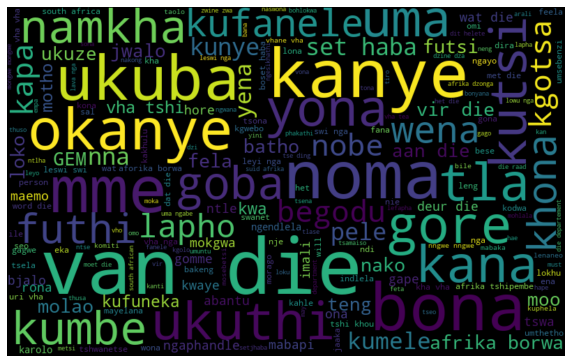

In [170]:
all_words = ' '.join([text for text in combi['tidy_text']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

#Bag-of-Words Features

In [171]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_text'])
bow.shape

(38682, 1000)

#TF-IDF Features

In [172]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_text'])
tfidf.shape

(38682, 1000)

#Word2Vec Features

###1.0 Word2Vec Embeddings

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

In [174]:
%%time
tokenized_text = combi['tidy_text'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_text,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_text, total_examples= len(combi['tidy_text']), epochs=20)


CPU times: user 10min 40s, sys: 1.23 s, total: 10min 41s
Wall time: 5min 36s


In [175]:
model_w2v.wv.most_similar(positive="food")

[('sustenance', 0.9376916289329529),
 ('automotive', 0.9373458623886108),
 ('footwear', 0.9328272342681885),
 ('drainage', 0.9297512769699097),
 ('intermediate', 0.9278039932250977),
 ('offshore', 0.9264064431190491),
 ('clothing', 0.9254456758499146),
 ('supports', 0.9243564605712891),
 ('technikons', 0.9239825010299683),
 ('shooting', 0.921413779258728)]

In [176]:
model_w2v.most_similar(positive="ukuba")

[('ngaba', 0.7029260396957397),
 ('wamagosa', 0.5784666538238525),
 ('irente', 0.5762131810188293),
 ('kumagumbi', 0.568055272102356),
 ('vavanyo', 0.5659321546554565),
 ('izizalwane', 0.5630699396133423),
 ('bungqina', 0.5624761581420898),
 ('azinikeleyo', 0.5623997449874878),
 ('awuzange', 0.5548620820045471),
 ('ukuzimasa', 0.5522661209106445)]

In [177]:
model_w2v['ukuba']

array([-0.1360068 , -0.08773724,  0.70336574, -0.15209553, -0.6253311 ,
       -0.76349247,  0.7901186 , -0.6288177 ,  1.158111  ,  0.42607006,
        0.31831074,  0.40024388, -0.36236626,  1.1532732 , -0.72175217,
        0.32682663, -0.3950469 ,  0.6466605 , -0.21446401,  0.01943795,
       -0.17225757,  0.363082  ,  0.14300835, -0.6653149 , -0.22914238,
       -0.8326243 ,  0.30958536,  0.05005104,  0.3953285 , -0.5888517 ,
        0.49345446,  0.11656579, -0.5436877 , -0.04839623,  0.19716448,
        0.07030333,  0.6553254 , -0.5362873 , -0.21273877,  0.19890238,
        0.01452408,  0.5627255 ,  0.77206933,  0.02554448,  0.38501203,
        0.3969418 ,  0.66920274, -0.6963925 ,  0.98080844, -0.49248683,
        0.27130905, -0.39920843, -0.79178613,  0.6019746 ,  0.03810793,
       -0.31543466, -0.4525474 ,  0.30994302, -0.09809274, -0.49703172,
       -0.06587911, -0.23991163, -0.1291701 , -0.1569464 , -0.00477954,
        0.7356709 ,  0.53973436, -0.48328972,  0.98116773, -0.36

In [178]:
len(model_w2v['food']) #The length of the vector is 200

200

###Preparing Vectors for text

In [179]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [180]:
wordvec_arrays = np.zeros((len(tokenized_text), 200)) 
for i in range(len(tokenized_text)):
    wordvec_arrays[i,:] = word_vector(tokenized_text[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(38682, 200)

##2. Doc2Vec Embedding

###More libraries

In [181]:
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence

####To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [182]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["text_" + str(i)]))
    return output

labeled_text = add_label(tokenized_text) # label all the tweets

In [183]:
labeled_text[:6]

[LabeledSentence(words=['umgaqo', 'siseko', 'wenza', 'amalungiselelo', 'kumaziko', 'axhasa', 'ulawulo', 'lwesininzi', 'kunye', 'nokuthath', 'inxaxheba', 'kwabafazi', 'ezi', 'ziquka', 'phakathi', 'kwezinye', 'zazo', 'ikomishoni', 'yokulingana', 'ngokwesini', 'ikomishoni', 'yamalungelo', 'oluntu', 'lomzantsi', 'afrika'], tags=['text_0']),
 LabeledSentence(words=['dha', 'iya', 'kuba', 'nobulumko', 'bokubeka', 'umsebenzi', 'naphi', 'kwisebe', 'ngokusekwe', 'kwiimfuno', 'zokusebenza', 'zalo', 'emva', 'kokubonana', 'nomsebenzi', 'kunye', 'okanye', 'imanyano', 'yakhe', 'ukuba', 'ulandulo', 'lomntu', 'onjalo', 'alufanelekanga', 'dha', 'mayibize', 'uncedo', 'olufanelekileyo', 'elungelweni', 'layo'], tags=['text_1']),
 LabeledSentence(words=['the', 'province', 'kwazulu', 'natal', 'department', 'transport', 'invites', 'tenders', 'from', 'established', 'contractors', 'experienced', 'bridge', 'construction', 'for', 'the', 'construction', 'the', 'kwajolwayo', 'tugela', 'river', 'pedestrian', 'bridge

##Now let’s train a doc2vec model.

In [184]:
%%time 
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_text)])

model_d2v.train(labeled_text, total_examples= len(train['tidy_text']), epochs=15)

100%|██████████| 38682/38682 [00:00<00:00, 664439.10it/s]


CPU times: user 2min 45s, sys: 28.9 s, total: 3min 14s
Wall time: 2min 12s


####Preparing doc2vec Feature Set

In [185]:
docvec_arrays = np.zeros((len(tokenized_text), 200)) 
for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(38682, 200)

In [186]:
docvec_df.shape,  wordvec_df.shape

((38682, 200), (38682, 200))

In [187]:
train.shape, test.shape

((33000, 3), (5682, 2))

In [ ]:
# Extracting train and test BoW features 
train_bow = bow[:33000,:] 
test_bow = bow[33000:,:]

#Encoding

Done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:


1.   Logistic Regression
2.   Support Vector Machine
3.   RandomForest
4.   XGBoost

###Encoding Cat Var

In [203]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Transforming categorical variable to label encoded form
train['lang_id'] = le.fit_transform(train['lang_id'])
# data['lang_id'] = le.inverse_transform(data['lang_id'])
# data['lang_id'] 

#Logistic Regression

In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

##Bag-of-Words Features

In [212]:
# Extracting train and test BoW features 
train_bow = bow[:33000,:] 
test_bow = bow[33000:,:]

# splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(train_bow, train['lang_id'], random_state=42, test_size=0.3)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(X_train, y_train) 

y_pred = lreg.predict(X_test) # predicting

In [216]:
#Metrics
# print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# pd.crosstab(y_test,y_pred)

0.9588888888888889
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       895
           1       0.91      1.00      0.95       909
           2       0.91      0.90      0.91       879
           3       0.99      0.99      0.99       941
           4       0.99      0.98      0.99       918
           5       0.94      0.92      0.93       908
           6       0.98      0.98      0.98       882
           7       1.00      0.99      1.00       857
           8       1.00      0.99      1.00       936
           9       0.93      0.92      0.92       922
          10       0.90      0.88      0.89       853

    accuracy                           0.96      9900
   macro avg       0.96      0.96      0.96      9900
weighted avg       0.96      0.96      0.96      9900



##TF-IDF Features


In [225]:
# Extracting train and test TF-IDF features 
train_tfidf = tfidf[:33000,:]
test_tfidf = tfidf[33000:,:] 

# splitting data into training and validation set 
tX_train, tX_test, ty_train, ty_test = train_test_split(train_tfidf, train['lang_id'], random_state=42, test_size=0.3)

td_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
td_lreg.fit(tX_train, ty_train) 

td_y_pred = td_lreg.predict(tX_test) # predicting

In [226]:
#Metrics
print(accuracy_score(ty_test, td_y_pred))
print(classification_report(ty_test, td_y_pred))


0.9626262626262626
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       0.94      1.00      0.97       909
           2       0.91      0.91      0.91       879
           3       0.99      0.99      0.99       941
           4       0.99      0.99      0.99       918
           5       0.94      0.92      0.93       908
           6       0.99      0.98      0.98       882
           7       1.00      1.00      1.00       857
           8       1.00      1.00      1.00       936
           9       0.94      0.92      0.93       922
          10       0.90      0.89      0.90       853

    accuracy                           0.96      9900
   macro avg       0.96      0.96      0.96      9900
weighted avg       0.96      0.96      0.96      9900



##Word2Vec Features

In [228]:
# Extracting train and test Word2Vec features 
train_w2v = wordvec_df.iloc[:33000,:]
test_w2v = wordvec_df.iloc[33000:,:]

# splitting data into training and validation set 
wX_train, wX_test, wy_train, wy_test = train_test_split(train_w2v, train['lang_id'], random_state=42, test_size=0.3)

w_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
w_lreg.fit(wX_train, wy_train) 

LogisticRegression()

In [229]:
w_y_pred = w_lreg.predict(wX_test) # predicting

In [237]:
#Metrics
print(accuracy_score(wy_test, w_y_pred))
print(classification_report(wy_test, w_y_pred))

0.9992929292929293
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00       909
           2       1.00      1.00      1.00       879
           3       1.00      1.00      1.00       941
           4       1.00      1.00      1.00       918
           5       1.00      1.00      1.00       908
           6       1.00      1.00      1.00       882
           7       1.00      1.00      1.00       857
           8       1.00      1.00      1.00       936
           9       1.00      1.00      1.00       922
          10       1.00      1.00      1.00       853

    accuracy                           1.00      9900
   macro avg       1.00      1.00      1.00      9900
weighted avg       1.00      1.00      1.00      9900



##Doc2Vec Features

In [232]:
# Extracting train and test Doc2Vec features 
train_d2v = docvec_df.iloc[:33000,:]
test_d2v = docvec_df.iloc[33000:,:]

# splitting data into training and validation set 
dX_train, dX_test, dy_train, dy_test = train_test_split(train_d2v, train['lang_id'], random_state=42, test_size=0.3)

d_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
d_lreg.fit(dX_train, dy_train) 

# predicting
d_y_pred = d_lreg.predict(dX_test) 

In [233]:
#Metrics
print(accuracy_score(dy_test, d_y_pred))
print(classification_report(dy_test, d_y_pred))

0.6932323232323232
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       895
           1       0.58      0.55      0.56       909
           2       0.76      0.82      0.79       879
           3       0.74      0.77      0.75       941
           4       0.73      0.78      0.76       918
           5       0.81      0.82      0.81       908
           6       0.74      0.79      0.77       882
           7       0.48      0.46      0.47       857
           8       0.48      0.41      0.44       936
           9       0.82      0.85      0.83       922
          10       0.77      0.79      0.78       853

    accuracy                           0.69      9900
   macro avg       0.69      0.69      0.69      9900
weighted avg       0.69      0.69      0.69      9900



#2.XGBoost


In [234]:
from xgboost import XGBClassifier

##Word2Vec Features

In [235]:
# training the model 
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3)
xgb.fit(wX_train, wy_train) 
xgb_y = xgb.predict(wX_test)

In [238]:
#Metrics
print(accuracy_score(wy_test, xgb_y))
print(classification_report(wy_test, xgb_y))

0.9981818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00       909
           2       0.99      1.00      1.00       879
           3       1.00      1.00      1.00       941
           4       1.00      1.00      1.00       918
           5       1.00      1.00      1.00       908
           6       1.00      1.00      1.00       882
           7       1.00      1.00      1.00       857
           8       1.00      1.00      1.00       936
           9       1.00      1.00      1.00       922
          10       1.00      1.00      1.00       853

    accuracy                           1.00      9900
   macro avg       1.00      1.00      1.00      9900
weighted avg       1.00      1.00      1.00      9900



In [239]:
#To predict the test data for kaggle submission.
final_pred = xgb.predict(test_w2v)

In [247]:
#Save Model With Pickle
import pickle

model_save_path = "xgb_model.pkl" #SVM
with open(model_save_path,'wb') as file:
    pickle.dump(xgb,file)

In [248]:
#Open Model With Pickle
model_load_path = "xgb_model.pkl"
with open(model_load_path,'rb') as file:
    unpickled_model = pickle.load(file)

In [249]:
# get predictions from unpickled model
xgb_pred = unpickled_model.predict(wX_test)

#FineTuning XGBoost + Word2Vec

In [252]:
# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
 }

#File Submission

In [240]:
sub = pd.read_csv(url_sub)
sub.head()

,index,lang_id
0,1,tsn
1,2,nbl


In [241]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['index'] = test['index']
submission['lang_id'] = final_pred # our model predictions on the test dataset
submission.head()

,index,lang_id
0,1,6
1,2,2
2,3,8
3,4,5
4,5,0


In [242]:
submission["lang_id"].replace({0: 'afr', 1: 'eng', 2: 'nbl', 3: 'nso', 4: 'sot', 5: 'ssw', 6: 'tsn', 7: 'tso', 8: 'ven', 9: 'xho', 10: 'zul'}, inplace=True)
print(submission)

      index lang_id
0         1     tsn
1         2     nbl
2         3     ven
3         4     ssw
4         5     afr
...     ...     ...
5677   5678     eng
5678   5679     nso
5679   5680     sot
5680   5681     sot
5681   5682     nbl

[5682 rows x 2 columns]


In [243]:
# for Kaggle submisison
submission.to_csv('South_Africa_Languages.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [244]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("South_Africa_Languages.csv")
submissions_check.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


In [245]:
submission.shape

(5682, 2)

In [253]:
from google.colab import files
files.download("South_Africa_Languages.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>